In [15]:
import numpy as np
import pandas as pd
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
h_start = 0.1
h_min = 0.02
a = np.sqrt(2)
noise_std = 0.2
n_points = 2000
eps = 1e-3

In [8]:
x_syn = np.linspace(eps, 1.0, n_points)
y_clean_syn = (1 + 0.5 * np.sin(4 * np.pi * x_syn)) * np.sin(2 * np.pi * (6 * x_syn + 12 * x_syn**3))

np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy_syn = y_clean_syn + noise

components_syn = []
residuals_list_syn = []
current_residuals_syn = y_noisy_syn.copy()

components_clean_syn = []
residuals_list_clean_syn = []
current_residuals_clean = y_clean_syn.copy()

In [9]:
h_curr = h_start
if len(x_syn) > 1:
    dx = (x_syn[-1] - x_syn[0]) / (len(x_syn) - 1)
else:
    dx = 1.0

while h_curr >= h_min:
    n_window = int(np.ceil(h_curr / dx))
    if n_window < 1: n_window = 1
    
    k_x = np.arange(-n_window, n_window + 1) * dx
    
    if h_curr == 0:
        weights = np.zeros_like(k_x)
        weights[len(weights)//2] = 1
    else:
        weights = 0.75 * (1 - (k_x / h_curr)**2)
        weights[weights < 0] = 0
        
    if weights.sum() > 0:
        weights = weights / weights.sum()

    denominator = fftconvolve(np.ones_like(current_residuals_syn), weights, mode='same')
    denominator_safe = denominator + 1e-10

    numerator_syn = fftconvolve(current_residuals_syn, weights, mode='same')
    y_smooth_syn = numerator_syn / denominator_safe
    
    components_syn.append(y_smooth_syn)
    current_residuals_syn = current_residuals_syn - y_smooth_syn
    residuals_list_syn.append(current_residuals_syn.copy())

    numerator_clean = fftconvolve(current_residuals_clean, weights, mode='same')
    y_smooth_clean = numerator_clean / denominator_safe
    
    components_clean_syn.append(y_smooth_clean)
    current_residuals_clean = current_residuals_clean - y_smooth_clean
    residuals_list_clean_syn.append(current_residuals_clean.copy())

    h_curr /= a

Iteration 1


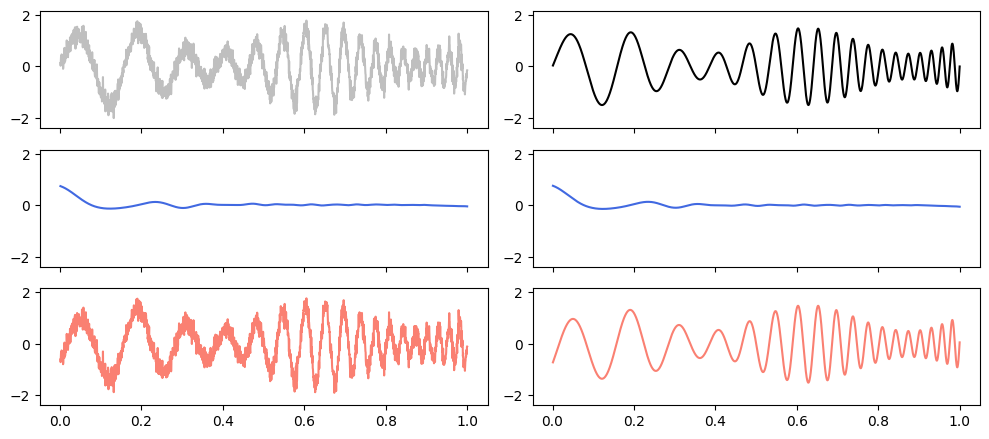

Iteration 2


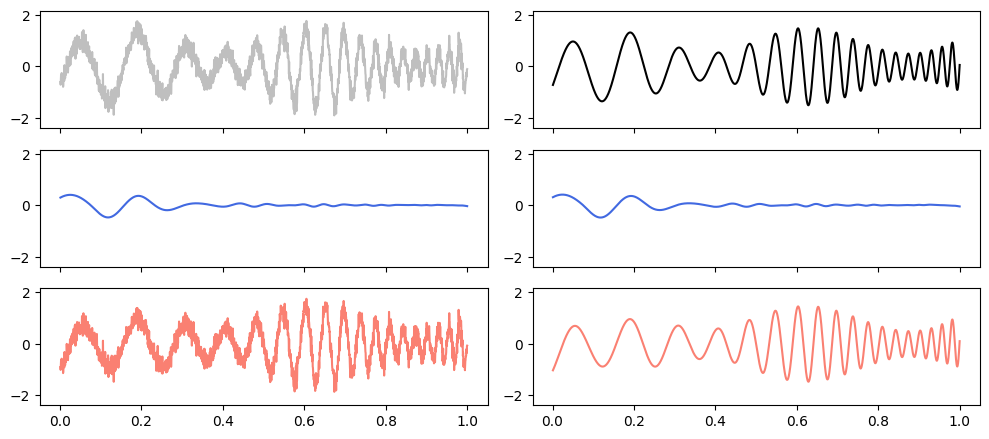

Iteration 3


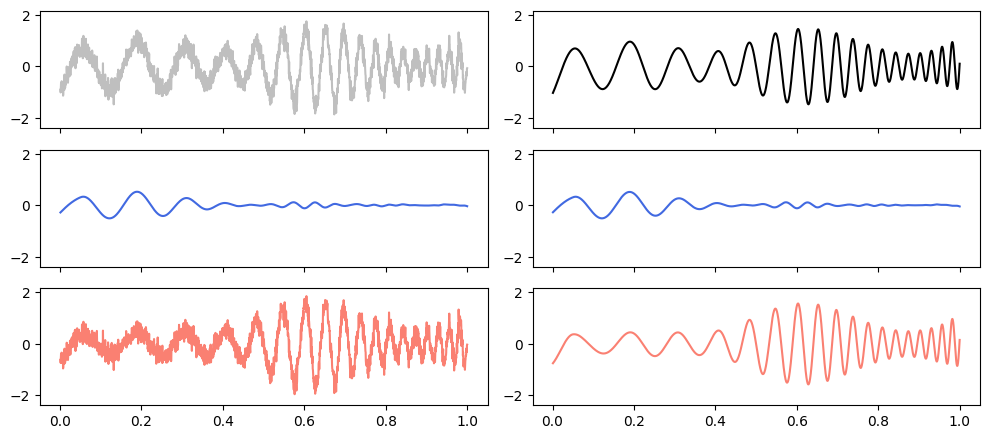

Iteration 4


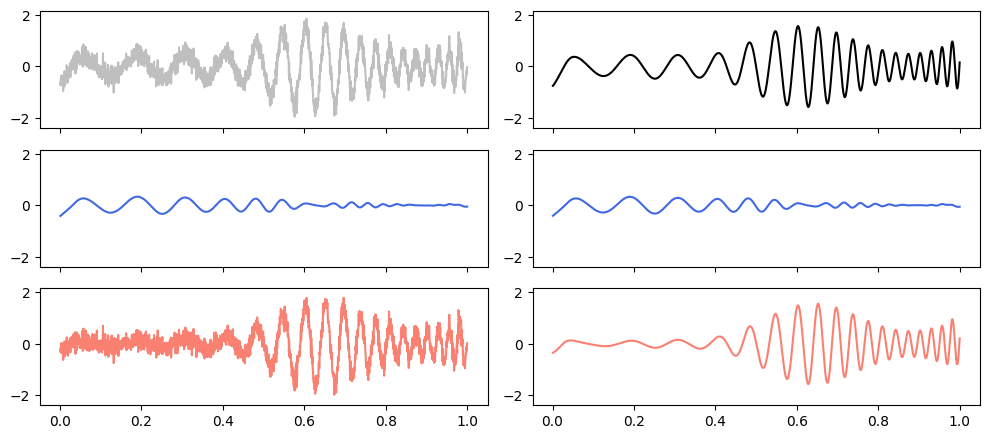

Iteration 5


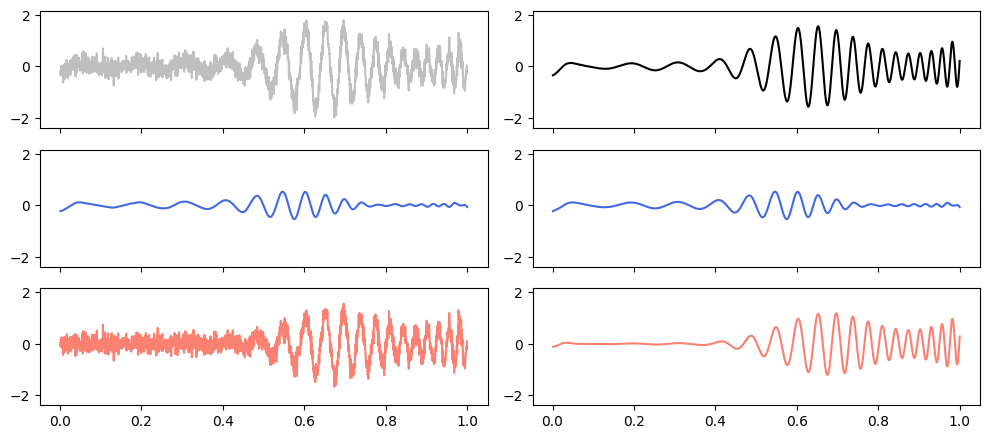

In [11]:
valid_data = y_noisy_syn[~np.isnan(y_noisy_syn)]
y_min = np.min(valid_data)
y_max = np.max(valid_data)
y_range = y_max - y_min
if y_range == 0: y_range = 1.0
ylim_lower = y_min - 0.1 * y_range
ylim_upper = y_max + 0.1 * y_range

for i in range(len(components_syn)):
    print(f"Iteration {i + 1}")
    if i == 0:
        curr_input_noisy = y_noisy_syn
        curr_input_clean = y_clean_syn
    else:
        curr_input_noisy = residuals_list_syn[i-1]
        curr_input_clean = residuals_list_clean_syn[i-1]

    fig, axes = plt.subplots(3, 2, figsize=(10, 4.5), sharex=True)

    axes[0, 0].plot(x_syn, curr_input_noisy, color='gray', linewidth=1.5, alpha=0.5)
    axes[1, 0].plot(x_syn, components_syn[i], color='royalblue', linestyle='-', linewidth=1.5)
    axes[2, 0].plot(x_syn, residuals_list_syn[i], color='salmon', linestyle='-', linewidth=1.5)

    axes[0, 1].plot(x_syn, curr_input_clean, color='black', linestyle='-', linewidth=1.5)
    axes[1, 1].plot(x_syn, components_clean_syn[i], color='royalblue', linestyle='-', linewidth=1.5)
    axes[2, 1].plot(x_syn, residuals_list_clean_syn[i], color='salmon', linestyle='-', linewidth=1.5)

    for ax_row in axes:
        for ax in ax_row:
            ax.set_ylim(ylim_lower, ylim_upper)
            
    plt.tight_layout()
    plt.show()

In [25]:
B = 100
sigma_values = np.linspace(0, 0.5, 6)
a_values = np.linspace(1.2, 3.2, 6)
sse_results = np.zeros((len(a_values), len(sigma_values)))

In [26]:
for i, a_val in enumerate(tqdm(a_values, desc="Simulating a values")):
    components_clean_ref = []
    current_residuals_clean_ref = y_clean_syn.copy()
    h_curr = h_start
    
    while h_curr >= h_min:
        n_window = int(np.ceil(h_curr / dx))
        if n_window < 1: n_window = 1
        
        k_x = np.arange(-n_window, n_window + 1) * dx
        
        if h_curr == 0:
            weights = np.zeros_like(k_x)
            weights[len(weights)//2] = 1
        else:
            weights = 0.75 * (1 - (k_x / h_curr)**2)
            weights[weights < 0] = 0
            
        if weights.sum() > 0:
            weights = weights / weights.sum()

        denominator = fftconvolve(np.ones_like(current_residuals_clean_ref), weights, mode='same')
        denominator_safe = denominator + 1e-10
        numerator = fftconvolve(current_residuals_clean_ref, weights, mode='same')
        y_smooth = numerator / denominator_safe
        
        components_clean_ref.append(y_smooth)
        current_residuals_clean_ref = current_residuals_clean_ref - y_smooth
        h_curr /= a_val

    for j, sigma_val in enumerate(sigma_values):
        sse_accum = 0.0
        
        for b in range(B):
            np.random.seed(b + i*1000 + j*10000)
            noise_b = np.random.normal(scale=sigma_val, size=n_points)
            y_noisy_b = y_clean_syn + noise_b
            
            components_noisy_b = []
            current_residuals_noisy_b = y_noisy_b.copy()
            h_curr_b = h_start
            
            while h_curr_b >= h_min:
                n_window = int(np.ceil(h_curr_b / dx))
                if n_window < 1: n_window = 1
                
                k_x = np.arange(-n_window, n_window + 1) * dx
                
                if h_curr_b == 0:
                    weights = np.zeros_like(k_x)
                    weights[len(weights)//2] = 1
                else:
                    weights = 0.75 * (1 - (k_x / h_curr_b)**2)
                    weights[weights < 0] = 0
                    
                if weights.sum() > 0:
                    weights = weights / weights.sum()

                denominator = fftconvolve(np.ones_like(current_residuals_noisy_b), weights, mode='same')
                denominator_safe = denominator + 1e-10
                numerator = fftconvolve(current_residuals_noisy_b, weights, mode='same')
                y_smooth = numerator / denominator_safe
                
                components_noisy_b.append(y_smooth)
                current_residuals_noisy_b = current_residuals_noisy_b - y_smooth
                h_curr_b /= a_val
            
            current_run_sse = 0.0
            n_comps = min(len(components_clean_ref), len(components_noisy_b))
            
            for k in range(n_comps):
                diff = components_noisy_b[k] - components_clean_ref[k]
                mse_k = np.mean(diff**2)
                current_run_sse += mse_k
            
            sse_accum += current_run_sse
        
        avg_sse = sse_accum / B
        sse_results[i, j] = avg_sse

Simulating a values: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


Average SSE Table (rows=a, cols=sigma):
     0.0       0.1       0.2       0.3       0.4       0.5
1.2  0.0  0.000078  0.000317  0.000713  0.001246  0.001998
1.6  0.0  0.000084  0.000345  0.000772  0.001379  0.002134
2.0  0.0  0.000092  0.000368  0.000809  0.001456  0.002238
2.4  0.0  0.000065  0.000254  0.000547  0.000955  0.001600
2.8  0.0  0.000072  0.000285  0.000650  0.001166  0.001769
3.2  0.0  0.000082  0.000335  0.000777  0.001352  0.002131


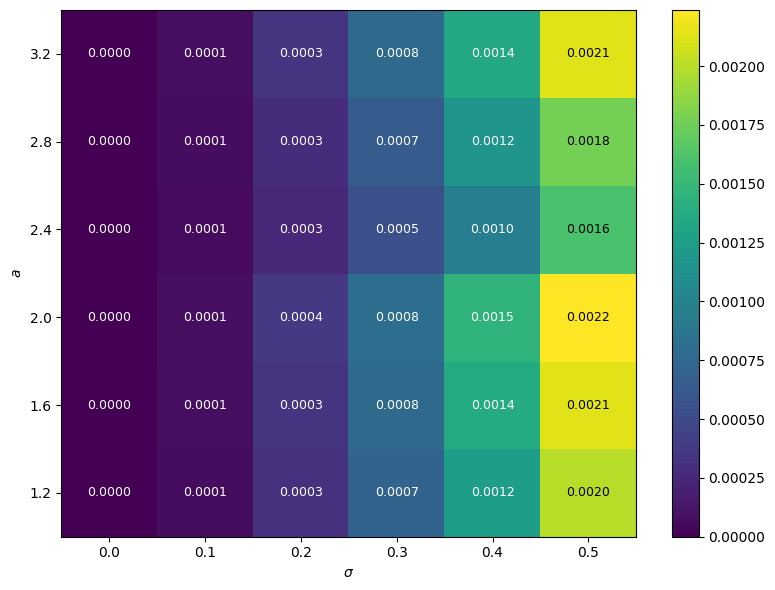

In [ ]:
df_sse = pd.DataFrame(sse_results, index=np.round(a_values, 2), columns=np.round(sigma_values, 2))
print("Average SSE Table:")
print(df_sse)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(sse_results, cmap='viridis', aspect='auto', origin='lower')

cbar = plt.colorbar(im)

ax.set_xticks(np.arange(len(sigma_values)))
ax.set_yticks(np.arange(len(a_values)))
ax.set_xticklabels(np.round(sigma_values, 2))
ax.set_yticklabels(np.round(a_values, 2))

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$a$')

for i in range(len(a_values)):
    for j in range(len(sigma_values)):
        val = sse_results[i, j]
        text_color = "black" if val > sse_results.max() * 0.7 else "white"
        ax.text(j, i, f"{val:.4f}", ha="center", va="center", color=text_color, fontsize=9)

plt.tight_layout()
plt.show()